## Clasificador de imagenes

In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm 
import cv2
import os

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dropout,Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
import keras_tuner as kt
from tensorflow import keras

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/gpiosenka/100-bird-species")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sebastian01973
Your Kaggle Key: ··········


100%|██████████| 1.96G/1.96G [00:23<00:00, 90.1MB/s]


In [ ]:
class_names= ['AFRICAN EMERALD CUCKOO',
 'AFRICAN OYSTER CATCHER',
 'AMERICAN COOT',
 'AMERICAN KESTREL',
 'ANDEAN SISKIN',
 'ANHINGA',
 'APAPANE',
 'APOSTLEBIRD',
 'ASIAN CRESTED IBIS',
 'AUSTRAL CANASTERO',
 ]
class_names_label={class_names:i for i, class_names in enumerate(class_names)}

In [ ]:
# path_actual = os.getcwd()
# ruta = f'{path_actual}/dataset/valid'

# import shutil
# for nombre_carpeta in os.listdir(ruta):
#     ruta_carpeta = os.path.join(ruta, nombre_carpeta)
#     if nombre_carpeta not in class_names:
#         # Eliminar la carpeta y su contenido
#         shutil.rmtree(ruta_carpeta)

In [ ]:
FAST_RUN =False
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH,IMAGE_HEIGHT)
IMAGE_CHANNELS=3  #3 para imagenes con color y 1 para blanco y negro
BATCH_SIZE=32
EPOCHS=20 #Maximo 20 empezar en 5
if FAST_RUN:
  EPOCHS=5

## Cargar el Dataset

In [ ]:
def load_data():
  datasets=["/content/dataset/train",
            "/content/dataset/valid",
            "/content/dataset/test"]
  output=[]

  for dataset in datasets:

    images=[]
    labels=[]
    print("Loading {}".format(dataset))

    for folder in os.listdir(dataset):
      label = class_names_label[folder]
      for file in tqdm(os.listdir(os.path.join(dataset,folder))):
        img_path = os.path.join(os.path.join(dataset,folder),file)
        image = cv2.imread(img_path,cv2.IMREAD_COLOR)
        if image is None:
          continue
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image,IMAGE_SIZE)
        images.append(image)
        labels.append(label)
    images = np.array(images)
    labels = np.array(labels)
    output.append((images,labels))
  return output

## Generador de imágenes (entrenamiento y validación)

In [ ]:
(train_images,train_labels),(val_images,val_labels),(test_images,test_labels)=load_data()

Loading /content/dataset/train


100%|██████████| 156/156 [00:00<00:00, 914.34it/s]


Loading /content/dataset/valid


100%|██████████| 5/5 [00:00<00:00, 399.02it/s]


Loading /content/dataset/test


100%|██████████| 5/5 [00:00<00:00, 676.61it/s]


In [ ]:
print(train_images.shape)
print(train_labels.shape)
print(val_images.shape)
print(val_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(1546, 224, 224, 3)
(1546,)
(50, 224, 224, 3)
(50,)
(50, 224, 224, 3)
(50,)


## Mostrar las imagenes

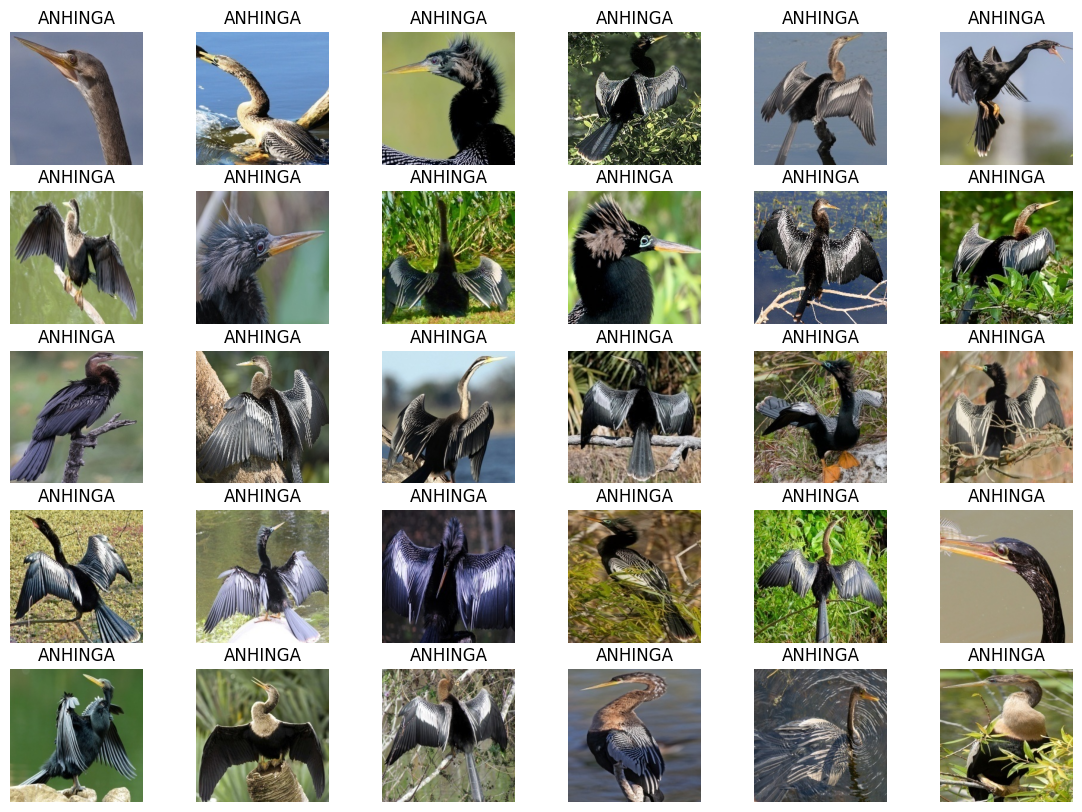

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14,10))
for n in range(1,31):
  fig.add_subplot(5, 6, n)
  img = train_images[n]
  plt.imshow(img)
  plt.title(class_names[train_labels[n]])
  plt.axis('off')

In [ ]:
from tensorflow.keras.utils import to_categorical
train_labels=to_categorical(train_labels,0)
val_labels=to_categorical(val_labels,0)
test_labels=to_categorical(test_labels,0)

In [ ]:
train_labels[100:1005]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
train_images, train_labels = shuffle(train_images,train_labels,random_state=42)
val_images, val_labels = shuffle(val_images, val_labels, random_state=42)
test_images, test_labels = shuffle(test_images, test_labels, random_state=42)

In [ ]:
path_actual = os.getcwd()
train_dir = f'{path_actual}/dataset/train'
test_dir = f'{path_actual}/dataset/test'

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=15,
    # shear_range=0.1,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # width_shift_range=0.1,
    # height_shift_range=0.1
)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=BATCH_SIZE,
    target_size=(224, 224), 
    class_mode="categorical",
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    batch_size=BATCH_SIZE,
    target_size=(224, 224), 
    class_mode="categorical",
    seed=42
)

Found 1546 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


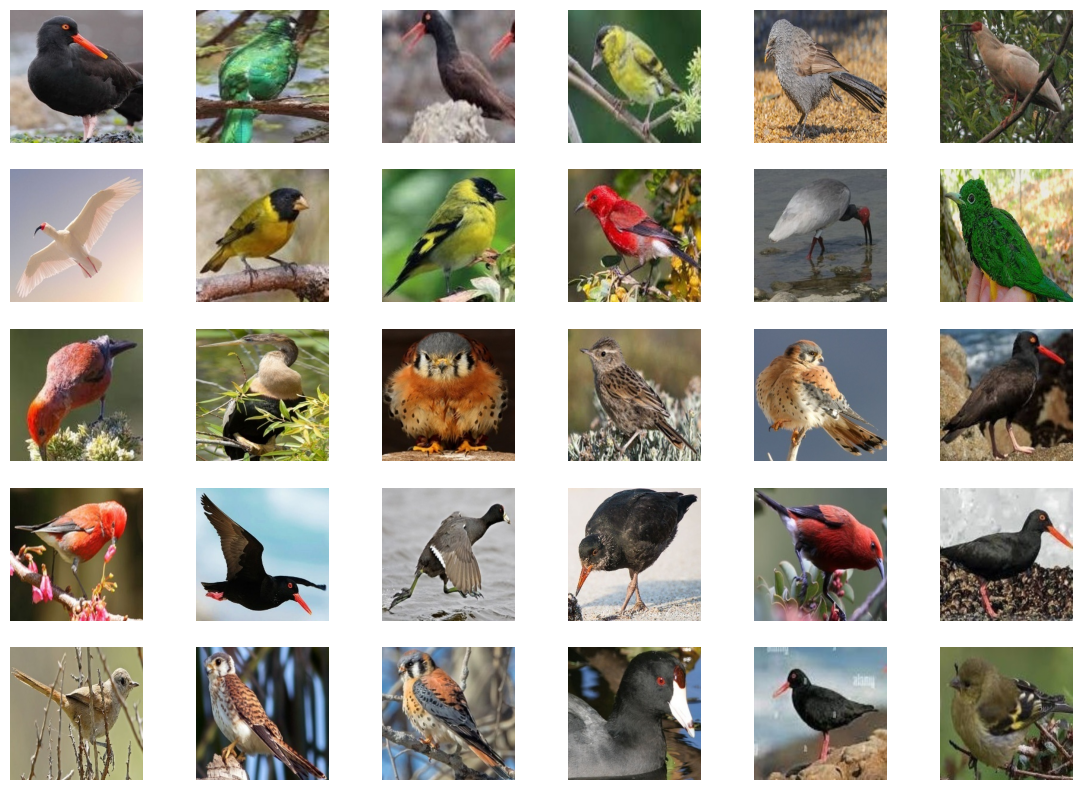

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14,10))
for n in range(1,31):
  fig.add_subplot(5, 6, n)
  img = train_images[n]
  
  plt.imshow(img)
  plt.axis('off')

## Creando el modelo de redes convolucionales

In [ ]:
model = Sequential()

# Convolution layers

model.add(Conv2D(32,(3, 3),input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64,(3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))


model.add(Conv2D(256, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))


model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(10))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(10))
model.add(BatchNormalization())
model.add(Activation('softmax'))


# Compile the model
model.compile(loss = "categorical_crossentropy",
                optimizer = "adam",
                metrics = ["accuracy"])

#Early stopping
callback = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)


## Entrenar el model

In [ ]:
history = model_5.fit(train_generator, epochs=100, callbacks=[callback], validation_data = test_generator)

Epoch 1/100
49/49 [==============================] - 286s 6s/step - loss: 1.8344 - accuracy: 0.3758 - val_loss: 2.4057 - val_accuracy: 0.1000
Epoch 2/100
49/49 [==============================] - 281s 6s/step - loss: 1.4810 - accuracy: 0.5472 - val_loss: 2.5524 - val_accuracy: 0.1200
Epoch 3/100
49/49 [==============================] - 281s 6s/step - loss: 1.3336 - accuracy: 0.6074 - val_loss: 2.5523 - val_accuracy: 0.1400
Epoch 4/100
49/49 [==============================] - 283s 6s/step - loss: 1.2385 - accuracy: 0.6630 - val_loss: 2.3929 - val_accuracy: 0.1800
Epoch 5/100
49/49 [==============================] - 281s 6s/step - loss: 1.1369 - accuracy: 0.7115 - val_loss: 2.3022 - val_accuracy: 0.1800
Epoch 6/100
49/49 [==============================] - 282s 6s/step - loss: 1.0608 - accuracy: 0.7400 - val_loss: 1.9435 - val_accuracy: 0.2600
Epoch 7/100
49/49 [==============================] - 283s 6s/step - loss: 1.0058 - accuracy: 0.7568 - val_loss: 1.8880 - val_accuracy: 0.3000
Epoch 

## Probar el modelo

In [ ]:
model_5.evaluate(test_generator)

2/2 [==============================] - 4s 1s/step - loss: 0.4455 - accuracy: 0.9400


[0.4454667568206787, 0.9399999976158142]

### Guardar el modelo entrenado

In [ ]:
model_5.save(os.path.join('models','newImage.h5'))

### Observar las predicciones

In [ ]:
y_pred = model_5.predict(test_generator)
y_pred[:5]

2/2 [==============================] - 2s 747ms/step


array([[2.6610696e-03, 1.0920669e-03, 7.8897347e-04, 2.5141072e-03,
        9.8842639e-01, 1.6975201e-04, 2.1295885e-03, 8.1807237e-05,
        1.2574013e-04, 2.0105264e-03],
       [1.6626352e-02, 3.9556935e-02, 9.5803775e-03, 9.3982983e-03,
        3.4238983e-02, 7.8872508e-01, 4.3636549e-02, 2.3321262e-02,
        1.6965678e-02, 1.7950563e-02],
       [5.4587801e-03, 2.1262614e-02, 2.1030003e-02, 3.0650739e-03,
        2.9105595e-03, 4.6394477e-03, 2.3043510e-02, 4.3899836e-03,
        8.8004100e-01, 3.4158979e-02],
       [6.6742606e-02, 4.6284139e-02, 1.5207390e-01, 8.1781089e-02,
        2.5193568e-02, 6.2440835e-02, 9.9380948e-02, 4.1292083e-02,
        3.8760573e-01, 3.7205152e-02],
       [3.9862427e-03, 5.1428691e-02, 7.4075414e-03, 3.7154827e-02,
        2.9865228e-02, 5.4244734e-02, 7.9725927e-01, 8.2059642e-03,
        2.8657394e-03, 7.5815646e-03]], dtype=float32)

In [ ]:
y_pred = y_pred.argmax(axis=1)
y_pred[:5]

array([4, 5, 8, 8, 6])

## Gráficas de entrenamiento y validación (accuracy - loss)

In [ ]:
def plotTraining(hist, epochs, typeData):
    
    if typeData=="loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'-r',label='Loss Training')
    if typeData=="accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-r',label='Accuracy Training')
    if typeData=="val_loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['val_loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'--b',label='Loss Validate')
    if typeData=="val_accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['val_accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'--b',label='Training Validate')
        

    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    plt.rc('legend', fontsize=18) 
    plt.legend()
    plt.xlabel('Number of Epochs',fontsize=24)
    plt.grid(True)

ValueError: ignored

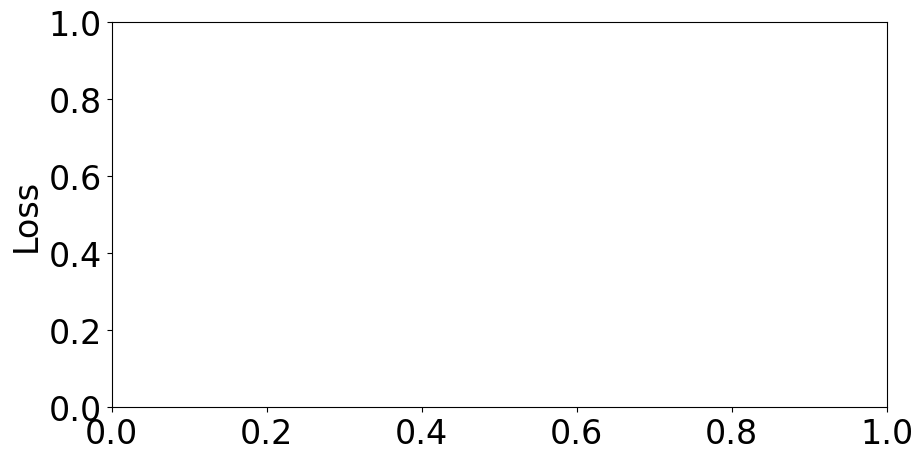

In [ ]:
plotTraining(history,10,"loss")
plotTraining(history,10,"accuracy")
plotTraining(history,10,"val_loss")
plotTraining(history,10,"val_accuracy")

## Prueba del modelo cargando una imagen

1/1 [==============================] - 0s 469ms/step
ANDEAN SISKIN


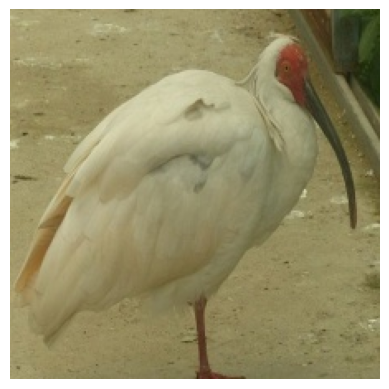

In [ ]:
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model
from keras.utils import np_utils
from tensorflow.keras.models import load_model # type: ignore

names= ['AFRICAN EMERALD CUCKOO',
 'AFRICAN OYSTER CATCHER',
 'AMERICAN COOT',
 'AMERICAN KESTREL',
 'ANDEAN SISKIN',
 'ANHINGA',
 'APAPANE',
 'APOSTLEBIRD',
 'ASIAN CRESTED IBIS',
 'AUSTRAL CANASTERO',
 ]

modelt = load_model("/content/models/newImage.h5",
                    custom_objects={'KerasLayer':hub.KerasLayer})
#modelt = custom_vgg_model

imaget_path = "/content/dataset/valid/ASIAN CRESTED IBIS/4.jpg"
imaget=cv2.resize(cv2.imread(imaget_path), (IMAGE_WIDTH, IMAGE_HEIGHT), interpolation = cv2.INTER_AREA)
xt = np.asarray(imaget)
xt=preprocess_input(xt)
xt = np.expand_dims(xt,axis=0)
preds = modelt.predict(xt)

print(names[np.argmax(preds)])
plt.imshow(cv2.cvtColor(np.asarray(imaget),cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()